In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.colors import LogNorm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path for config
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

# Import path for src
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import utils as utils
from config import *

In [5]:
csv_file = data_meta / "info_combined.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

# Read masks image and corresponding intensity measurement

In [6]:
# Read mask image
masks = utils.get_masks(data_mask)

# Create image based on intensity level of expression 

In [7]:
df_intensity = pd.read_csv(data_meta / "measurements_intensity.csv")
df_morph = pd.read_csv(data_meta / "measurements_morphology.csv")
markers = df_intensity.Marker.unique()

In [8]:
# Calculate total intensity from mena intensity and area size
for row in df_intensity.itertuples():
    cond = row.Location
    i = row.Id
    total_nuclei_intensity = (
        row.Nuclei_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)][
            "Nuclei_area"
        ].item()
    )
    total_cyto_intensity = (
        row.Cyto_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)]["Cyto_area"].item()
    )
    df_intensity.loc[row.Index, "Nuclei_total_intensity"] = total_nuclei_intensity
    df_intensity.loc[row.Index, "Cyto_total_intensity"] = total_cyto_intensity

In [9]:
df_intensity

,Cell_mean_intensity,Nuclei_mean_intensity,Cyto_mean_intensity,Marker,Location,Id,Nuclei_total_intensity,Cyto_total_intensity
0,11788.158099,32185.806775,567.825916,Hoeschst,1,1,144417715.0,4631756.0
1,7382.506802,12458.758859,4590.163663,p-EGFR,1,1,55902451.0,37441965.0
2,8268.703417,9150.794295,7783.483143,PCNA,1,1,41059614.0,63489872.0
3,11672.761784,27605.816136,2908.312247,B-actin,1,1,123867297.0,23723103.0
4,9937.847438,17099.909962,5998.142332,Phalloidin,1,1,76727296.0,48926847.0
...,...,...,...,...,...,...,...,...
86420,5692.377801,7927.878788,5606.558568,B-tubin,9,53,3401060.0,62653292.0
86421,3570.571269,3431.109557,3575.925101,Cyclin D1,9,53,1471946.0,39960963.0
86422,1343.401586,13554.449883,874.628456,H3k27me3-488,9,53,5814859.0,9773973.0
86423,2495.286281,3918.272727,2440.658881,H3k4me3-647,9,53,1680939.0,27274363.0


In [10]:
df_morph

,Cell_area,Nuclei_area,Cyto_area,Marker,Location,Id
0,12644,4487,8157,Hoeschst,1,1
1,23141,7083,16058,Hoeschst,1,2
2,27942,5419,22523,Hoeschst,1,3
3,84133,11165,72968,Hoeschst,1,4
4,36288,7265,29023,Hoeschst,1,5
...,...,...,...,...,...,...
3452,34558,8668,25890,Hoeschst,9,49
3453,30426,5676,24750,Hoeschst,9,50
3454,21132,817,20315,Hoeschst,9,51
3455,17940,1877,16063,Hoeschst,9,52


We have {{len(markers)}} markers (no including DAPI and cell segmentation markers) 

# Vizualisation

In [11]:
def get_data_per_condition(df, condition=None):
    # Read information
    df_list = []
    df_cell_intensity = df.iloc[:, 3:-1]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location.isin(condition)]
        df_subset['Id'] =  df.Location.astype(str) + "_" + df.Id.astype(str)
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(columns={"Nuclei_total_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Nuclei"
    df_list.append(df_subset)

    df_cell_intensity = df.iloc[:, [3, 4, 5, 7]]
    if condition:
        df_subset = df_cell_intensity[df_cell_intensity.Location.isin(condition)]
        df_subset['Id'] =  df.Location.astype(str) + "_" + df.Id.astype(str)
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df_cell_intensity.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(columns={"Cyto_total_intensity": "Intensity"}, inplace=True)
    df_subset["Location"] = "Cyto"
    df_list.append(df_subset)

    df_subset = pd.concat(df_list)
#     df_subset['Intensity'] = df_subset.groupby('Marker').Intensity.transform(lambda x: (x - x.mean()) / x.std())
    df_subset['Intensity'] = df_subset.groupby('Marker').Intensity.transform(lambda x: (x - x.min()) / (x.max()-x.min()))
    
    # Pivot the dataframe
    df_per_cell = (
        df_subset.set_index(["Id", "Marker", "Location"])
        .unstack()
        .unstack()
        .droplevel(0, axis=1)
    )

    return df_per_cell

## Per FOV

In [12]:
# scaler = MinMaxScaler()
# my_cmap = "viridis"
scale_name = "Relative Intensity"

# scaler = StandardScaler()
my_cmap = 'bwr'
# scale_name = 'Z-score'



In [25]:
location = '1'
locations = ['1']  # Select the condition

df_per_cell_scaled = get_data_per_condition(df_intensity, condition=locations)
df_per_cell_scaled.head()

ValueError: Length mismatch: Expected axis has 0 elements, new values have 172850 elements

In [ ]:
# Heatmap combined
fig, ax = plt.subplots(figsize=(25,7))
ax = sns.heatmap(
    df_per_cell_scaled.T, cbar_kws={"fraction": 0.01}, cmap=my_cmap, norm=LogNorm(vmin=0.0001, vmax=1)
)
ax.set_xticklabels('')
ax.tick_params(bottom=False)
ax.set_ylabel("Marker and location")
ax.set_xlabel("Cell")

# Change colorbar label position
cbar = ax.collections[0].colorbar
cbar.set_label(scale_name, fontsize=10)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

fig.savefig(figure_dir / 'heatmap' / f'{location}_hm.png', bbox_inches='tight')

# Clustermap
ax = sns.clustermap(
    df_per_cell_scaled.T,
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    col_cluster=False,
    dendrogram_ratio=(0.05, 0.0),
    cbar_pos=(0, 0.2, 0.01, 0.2),
    norm=LogNorm(vmin=0.0001, vmax=1), 
    figsize=(25,7),
)
ax.ax_heatmap.set_xticklabels('')
ax.ax_heatmap.tick_params(bottom=False)
ax.ax_heatmap.set_ylabel("Marker")
ax.ax_heatmap.set_xlabel("Cell")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=12, labelpad=-70)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

ax.savefig(figure_dir / 'heatmap' / f'{location}_cm.png', bbox_inches='tight')


## All FOV

In [14]:
df_per_cell_scaled = get_data_per_condition(df_intensity)
df_per_cell_scaled.head()

Location      Cyto                                                    \
Marker         AKT       APC     AXIN1   B-actin   B-tubin Cyclin D1   
Id                                                                     
10_1      0.014751  0.009434  0.010506  0.027127  0.019270  0.018431   
10_10     0.151520  0.073964  0.099450  0.094624  0.154659  0.206524   
10_11     0.058239  0.031797  0.035376  0.050360  0.070403  0.094372   
10_12     0.026049  0.023059  0.009558  0.017551  0.029771  0.043275   
10_13     0.010340  0.032406  0.009544  0.034569  0.014322  0.012515   

Location                                          ...          Nuclei  \
Marker    Cyclin E      DKK1      DKK2      EGFR  ... Non-p-B-catenin   
Id                                                ...                   
10_1      0.025072  0.019266  0.023437  0.027144  ...        0.009408   
10_10     0.261234  0.142633  0.208501  0.182001  ...        0.031973   
10_11     0.093494  0.069998  0.097041  0.093118  ...        0.022190   
10_12     0.063126  0.041034  0.049556  0.048246  ...        0.015590   
10_13     0.048927  0.028826  0.017989  0.021282  ...        0.018625   

Location                                                               \
Marker        PCNA Phalloidin    RNF 43      Wnt1      mTOR     p-AKT   
Id                                                                      
10_1      0.009685   0.012423  0.009665  0.003770  0.007131  0.009884   
10_10     0.027835   0.062108  0.027272  0.020803  0.025631  0.037361   
10_11     0.021953   0.047099  0.020131  0.007920  0.017487  0.024930   
10_12     0.018874   0.035489  0.016791  0.009073  0.013019  0.017941   
10_13     0.006402   0.028055  0.005052  0.007079  0.006799  0.018530   

Location                                  
Marker   p-B-catenin    p-EGFR    p-mTOR  
Id                                        
10_1        0.007967  0.013160  0.004980  
10_10       0.034906  0.042943  0.025479  
10_11       0.025562  0.026152  0.016272  
10_12       0.018089  0.020187  0.009403  
10_13       0.005996  0.031491  0.003886  

[5 rows x 50 columns]

C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


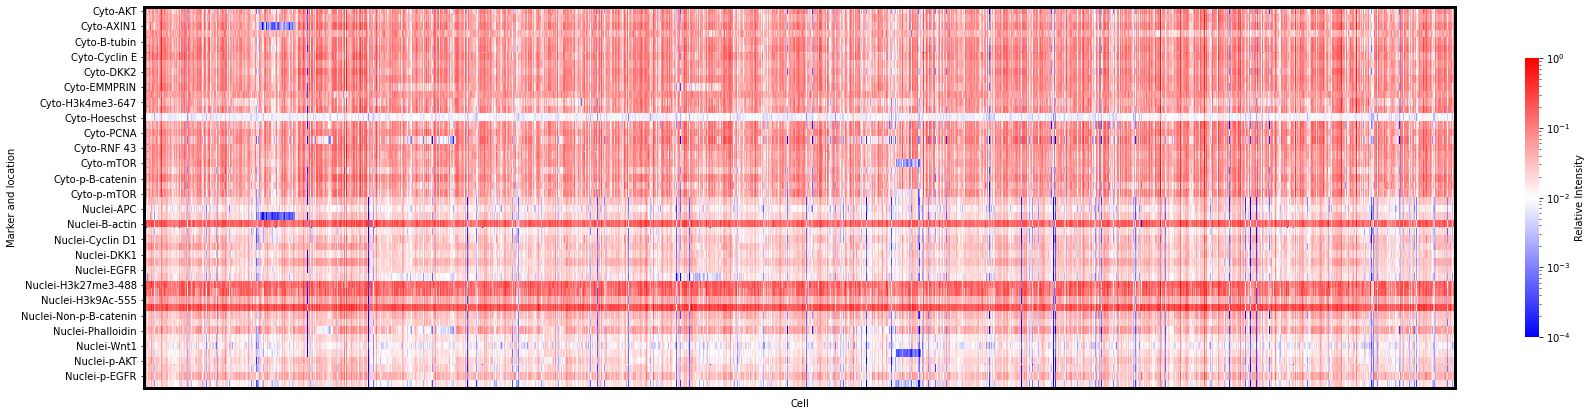

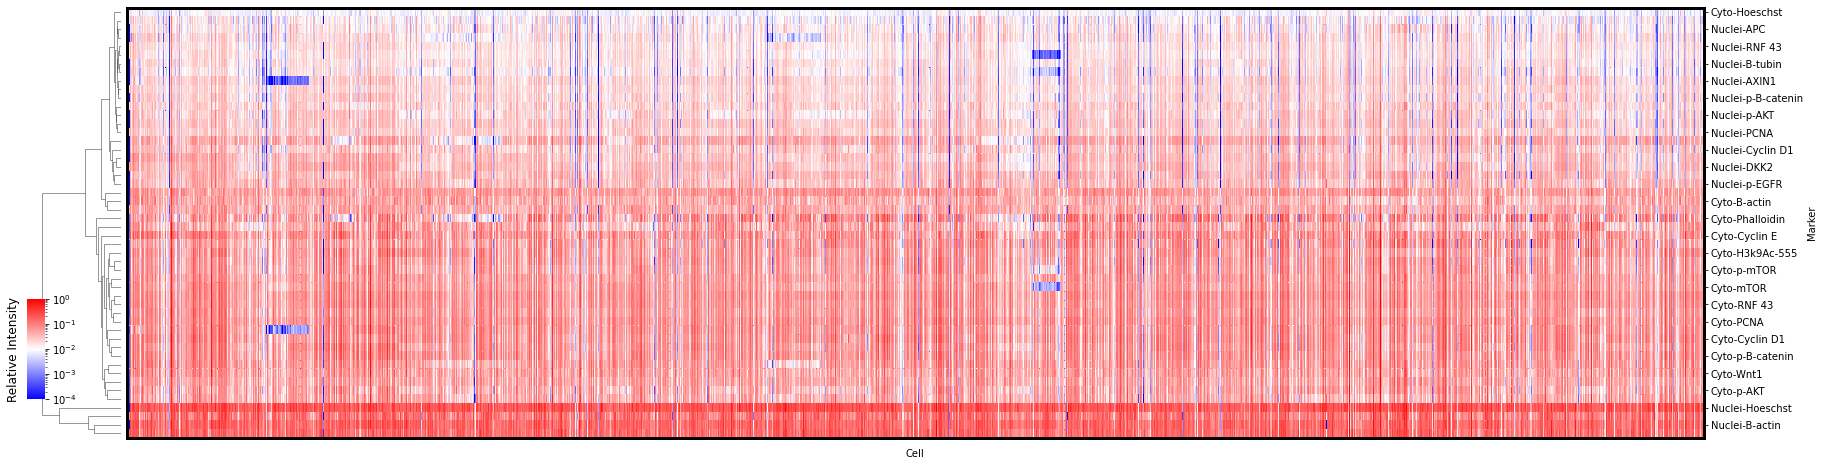

In [15]:
from matplotlib.colors import LogNorm

# Heatmap combined
fig, ax = plt.subplots(figsize=(25,7))
ax = sns.heatmap(
    df_per_cell_scaled.T, cbar_kws={"fraction": 0.01}, cmap=my_cmap, norm=LogNorm(vmin=0.0001, vmax=1)
)
ax.set_xticklabels('')
ax.tick_params(bottom=False)
ax.set_ylabel("Marker and location")
ax.set_xlabel("Cell")

# Change colorbar label position
cbar = ax.collections[0].colorbar
cbar.set_label(scale_name, fontsize=10)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

# Clustermap
ax = sns.clustermap(
    df_per_cell_scaled.T,
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    col_cluster=False,
    dendrogram_ratio=(0.05, 0.0),
    cbar_pos=(0, 0.2, 0.01, 0.2),
    norm=LogNorm(vmin=0.0001, vmax=1),
    figsize=(25,7),
)
ax.ax_heatmap.set_xticklabels('')
ax.ax_heatmap.tick_params(bottom=False)
ax.ax_heatmap.set_ylabel("Marker")
ax.ax_heatmap.set_xlabel("Cell")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=12, labelpad=-70)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

# Umap of cell 

In [16]:
from sklearn.decomposition import PCA
import umap
import parc

In [17]:
X = df_per_cell_scaled.values
parc1 = parc.PARC(X, jac_weighted_edges = False, random_seed=0)
parc1.run_PARC() 
parc_labels = parc1.labels

graph = parc1.knngraph_full()
embeddings = parc1.run_umap_hnsw(X, graph, random_state = 1)

input data has shape 3457 (samples) x 50 (features)
knn struct was not available, so making one
commencing local pruning based on Euclidean distance metric at 3 s.dev above mean
commencing global pruning
commencing community detection
partition type MVP
list of cluster labels and populations 12 [(0, 445), (1, 416), (2, 404), (3, 389), (4, 341), (5, 314), (6, 288), (7, 263), (8, 200), (9, 165), (10, 120), (11, 112)]
time elapsed 3.5 seconds
a,b, spread, dist 1.5769434603935901 0.8950608781603765 1.0 0.1
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


In [18]:
# %%time
# print('Umap embedding')
# embeddings = umap.UMAP().fit_transform(df_per_cell_scaled)


Text(0, 0.5, 'Umap 2')

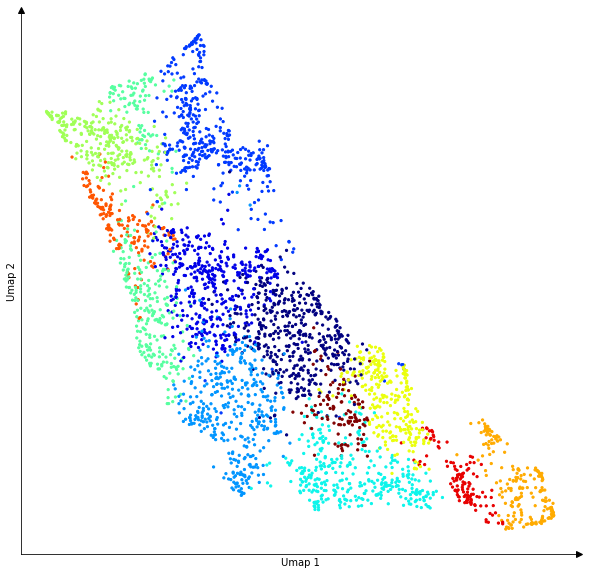

In [19]:
name = 'Umap'

fig, ax = plt.subplots(figsize=(10, 10))
X, Y = embeddings[:, 0], embeddings[:, 1]
ax.scatter(X, Y, c=parc_labels, s=5, cmap='jet')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Add arrow with spine
pos = ax.get_position()
ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

# Add label
ax.set_xlabel(f'{name} 1')
ax.set_ylabel(f'{name} 2')

In [20]:
cell_id = df_per_cell_scaled.index.tolist()

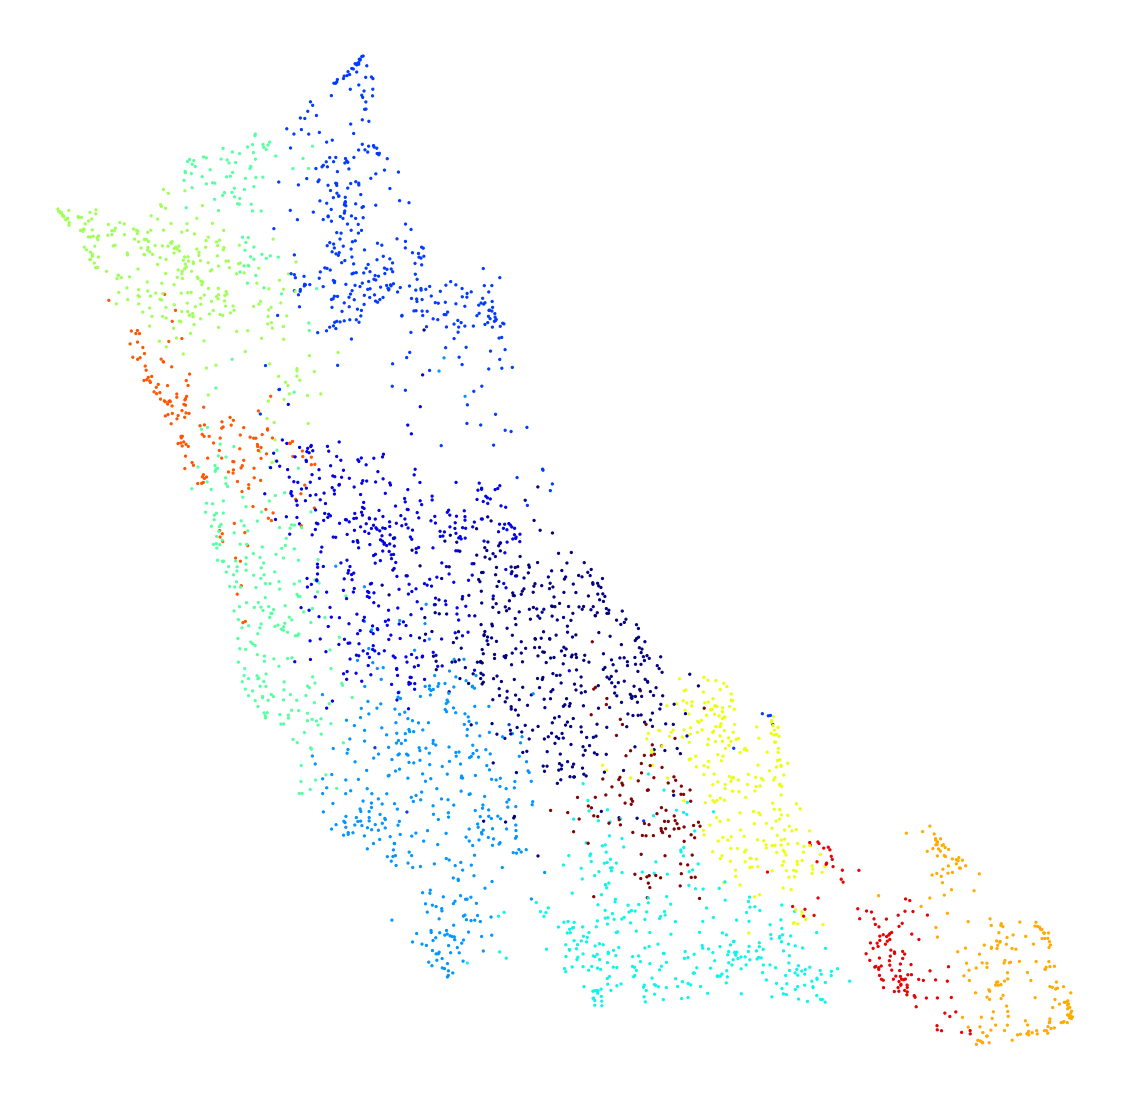

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))
X, Y = embeddings[:, 0], embeddings[:, 1]
ax.scatter(X, Y, c=parc_labels, s=5, cmap='jet')
ax.axis('off')

for i, txt in enumerate(cell_id):
    if '1_1_42' in txt:
        ax.annotate(txt, xy=(X[i], Y[i]), arrowprops=dict(facecolor='black', shrink=0.05))

In [22]:
df_scatter = pd.DataFrame({'cell': cell_id, 'cluster':parc_labels})

In [23]:
clusters = df_scatter.cluster.unique()

In [24]:
for cluster in clusters:
    display(df_scatter[df_scatter.cluster == cluster].head(10))

,cell,cluster
0,10_1,8
7,10_16,8
29,10_37,8
38,11_1,8
49,11_2,8
81,11_5,8
85,11_53,8
94,12_10,8
116,12_30,8
126,12_4,8


,cell,cluster
1,10_10,9
35,10_7,9
96,12_12,9
98,12_14,9
106,12_21,9
108,12_23,9
142,13_18,9
147,13_22,9
160,13_34,9
165,13_39,9


,cell,cluster
2,10_11,0
6,10_15,0
12,10_20,0
32,10_4,0
51,11_21,0
62,11_32,0
82,11_50,0
87,11_55,0
117,12_31,0
129,12_5,0


,cell,cluster
3,10_12,7
4,10_13,7
39,11_10,7
40,11_11,7
41,11_12,7
69,11_39,7
74,11_43,7
77,11_46,7
78,11_47,7
83,11_51,7


,cell,cluster
5,10_14,1
33,10_5,1
34,10_6,1
37,10_9,1
43,11_14,1
44,11_15,1
45,11_16,1
48,11_19,1
53,11_23,1
57,11_27,1


,cell,cluster
8,10_17,5
14,10_22,5
16,10_24,5
20,10_28,5
24,10_31,5
27,10_34,5
54,11_24,5
55,11_25,5
67,11_37,5
86,11_54,5


,cell,cluster
9,10_18,6
10,10_19,6
15,10_23,6
17,10_25,6
19,10_27,6
36,10_8,6
46,11_17,6
47,11_18,6
56,11_26,6
58,11_28,6


,cell,cluster
11,10_2,4
23,10_30,4
30,10_38,4
59,11_29,4
66,11_36,4
68,11_38,4
76,11_45,4
79,11_48,4
80,11_49,4
84,11_52,4


,cell,cluster
13,10_21,3
18,10_26,3
22,10_3,3
25,10_32,3
42,11_13,3
52,11_22,3
75,11_44,3
120,12_34,3
125,12_39,3
130,12_6,3


,cell,cluster
21,10_29,2
26,10_33,2
28,10_35,2
50,11_20,2
60,11_30,2
61,11_31,2
63,11_33,2
105,12_20,2
110,12_25,2
113,12_28,2


,cell,cluster
31,10_39,10
70,11_4,10
88,11_56,10
89,11_57,10
93,12_1,10
115,12_3,10
144,13_2,10
146,13_21,10
155,13_3,10
177,13_5,10


,cell,cluster
65,11_35,11
122,12_36,11
179,13_51,11
181,13_7,11
196,14_21,11
235,14_9,11
293,15_62,11
323,16_24,11
343,16_43,11
358,17_13,11
